# Bank marketing campaigns dataset analysis

### Abstract
This is dataset that describe Portugal bank marketing campaigns results.
Conducted campaigns were based mostly on direct phone calls, offering  bank's clients to place a term deposit.
If after all marking afforts client had agreed to place deposit - target variable marked 'yes', otherwise 'no'.

Sourse of the data
https://archive.ics.uci.edu/ml/datasets/bank+marketing

Dataset description
https://www.kaggle.com/volodymyrgavrysh/bank-marketing-campaigns-data-set-description

**Citation Request:**
> This dataset is public available for research. The details are described in S. Moro, P. Cortez and P. Rita. "A Data-Driven Approach to Predict the Success of Bank Telemarketing." Decision Support Systems, Elsevier, 62:22-31, June 2014 <


### Task

* predicting the future results of marketing companies based on available statistics and, accordingly, formulating recommendations for such companies in the future.
* building a profile of a consumer of banking services (deposits).

### Feature description
**Bank client data:**
* 1 - age (numeric)
* 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* 4 - education (categorical: basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* 5 - default: has credit in default? (categorical: 'no','yes','unknown')
* 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
* 7 - loan: has personal loan? (categorical: 'no','yes','unknown')

***Related with the last contact of the current campaign:***
* 8 - contact: contact communication type (categorical: 'cellular','telephone')
* 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

***other attributes:***
* 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* 14 - previous: number of contacts performed before this campaign and for this client (numeric)
* 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

***social and economic context attributes***
* 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
* 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
* 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
* 20 - nr.employed: number of employees - quarterly indicator (numeric)

***Output variable (desired target):***
* 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

# Setting Up

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 897.7 kB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import time
import gc
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm

# 1. Loading data and holding a short Expanatory Data Analysis

## Getting Data

In [ ]:
# pull data from github
data = pd.read_csv("https://raw.githubusercontent.com/PacktWorkshops/The-Data-Analysis-Workshop/master/Chapter03/data/bank-additional/bank-additional-full.csv", sep=";")

# visualize the head of the dataset
data.head().T

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


In [ ]:
bank_data = data

In [ ]:
display('There is {} observations with {} features'.format(data.shape[0], data.shape[1]))

'There is 41188 observations with 21 features'

## 1. Explore categorical features (EDA)

In [ ]:
def plot_bar(column, rotation):
    # Temporary DataFrame
    temp_1 = pd.DataFrame()

    # Count categorical values
    temp_1['No_deposit'] = data[data['y'] == 'no'][column].value_counts()
    temp_1['Yes_deposit'] = data[data['y'] == 'yes'][column].value_counts()

    # Create a plot
    ax = temp_1.plot(kind='bar', color=['blue', 'orange'])

    # Set title
    plt.title('{}'.format(column))

    # Hide specific spines (borders)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Keep bottom and left spines visible as you specified
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    # Do not set x-axis label
    plt.xlabel('')  # This line is commented out to not display the x-axis title

    # Rotate x-axis labels
    plt.xticks(rotation=rotation)  # Rotate labels to 45 degrees

    # Show the plot
    plt.show()

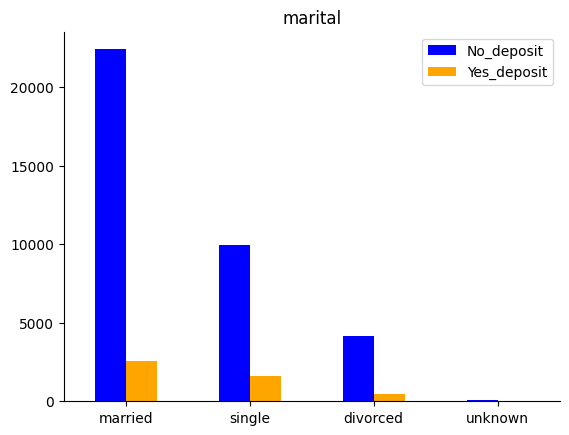

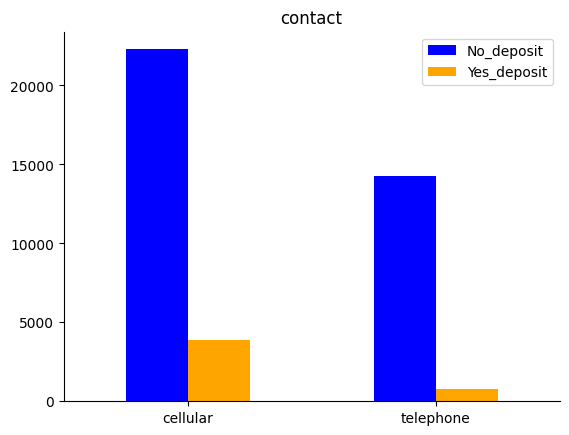

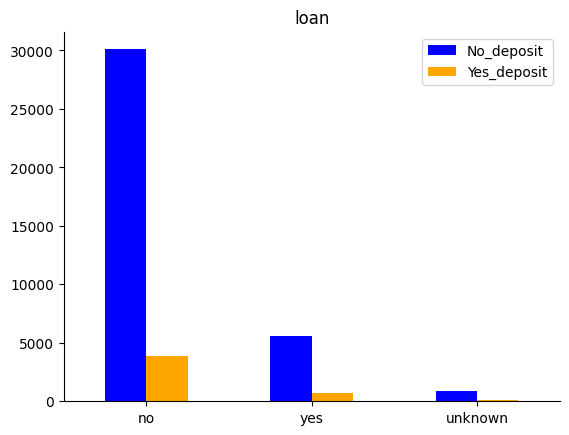

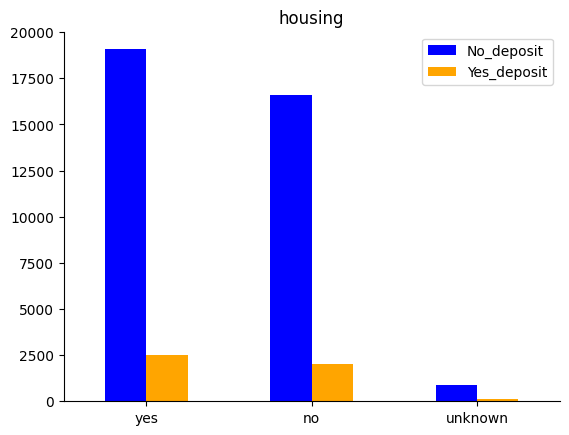

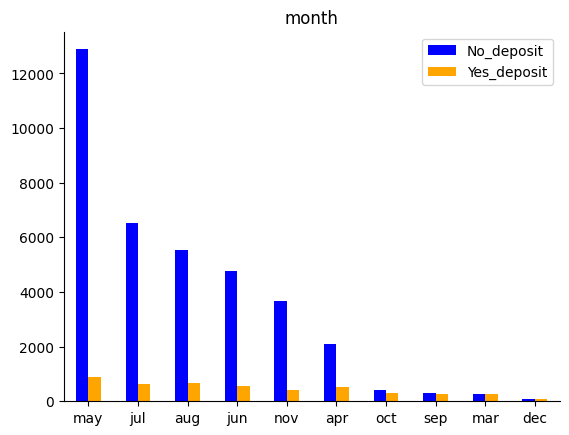

(None, None, None, None, None)

In [ ]:
plot_bar('marital', 0), plot_bar('contact', 0), plot_bar('loan', 0), plot_bar('housing', 0), plot_bar('month', 0)

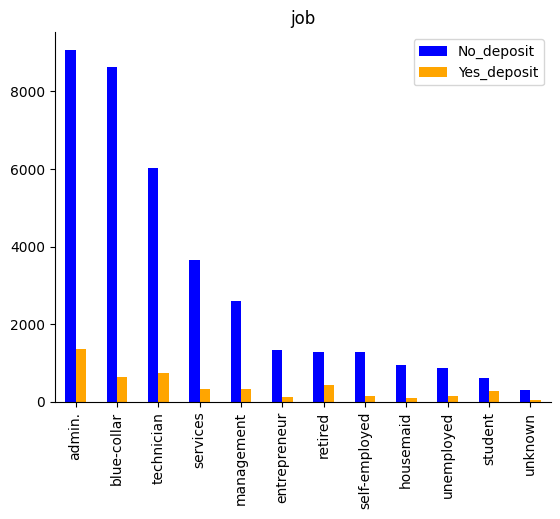

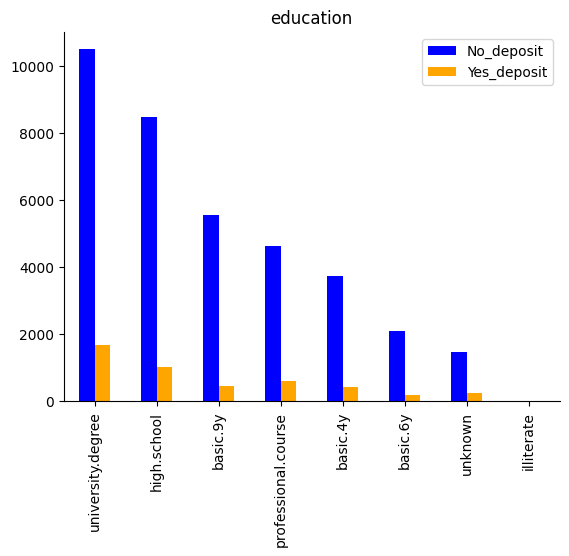

(None, None)

In [ ]:
plot_bar('job', 90), plot_bar('education', 90)

**Primary analysis of several categorical features reveals:**
1. Administrative staff and technical specialists opened the deposit most of all. In relative terms, a high proportion of pensioners and students might be mentioned as well.
2. Although in absolute terms married consumers more often agreed to the service, in relative terms the single was responded better.
3. Best communication channel is secullar.
4. The difference is evident between consumers who already use the services of banks and received a loan.
5. Home ownership does not greatly affect marketing company performance.

## 2. Explore numerical features (EDA)

In [ ]:
# Convert target variable into numeric
data.y = data.y.map({'no':0, 'yes':1}).astype('uint8')

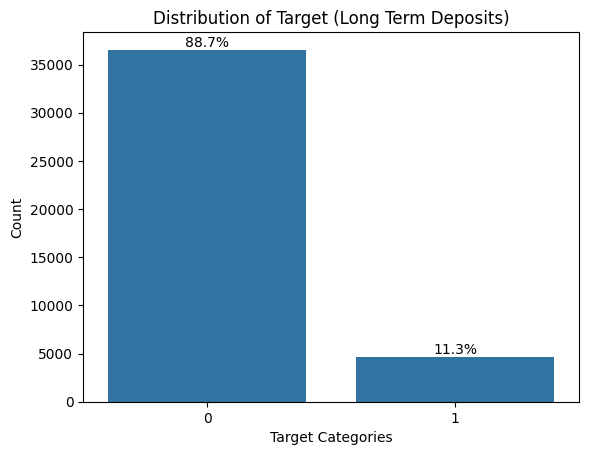

In [ ]:
# Create a bar plot for target distribution
ax = sns.countplot(data=data, x=data.y)  # Replace "target" with your actual target column name
plt.title("Distribution of Target (Long Term Deposits)")
plt.xlabel("Target Categories")
plt.ylabel("Count")

# Annotate bars with percentages
total_count = len(data)  # Total number of data points
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.annotate(f"{percentage:.1f}%", (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

In [ ]:
# Build correlation matrix
# Select only the numeric columns
numeric_columns = data.select_dtypes(include=np.number)

# Calculate the correlation matrix for numeric columns
corr_matrix = numeric_columns.corr()

# Display the correlation matrix with a color gradient
corr_matrix.style.background_gradient(cmap='PuBu')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


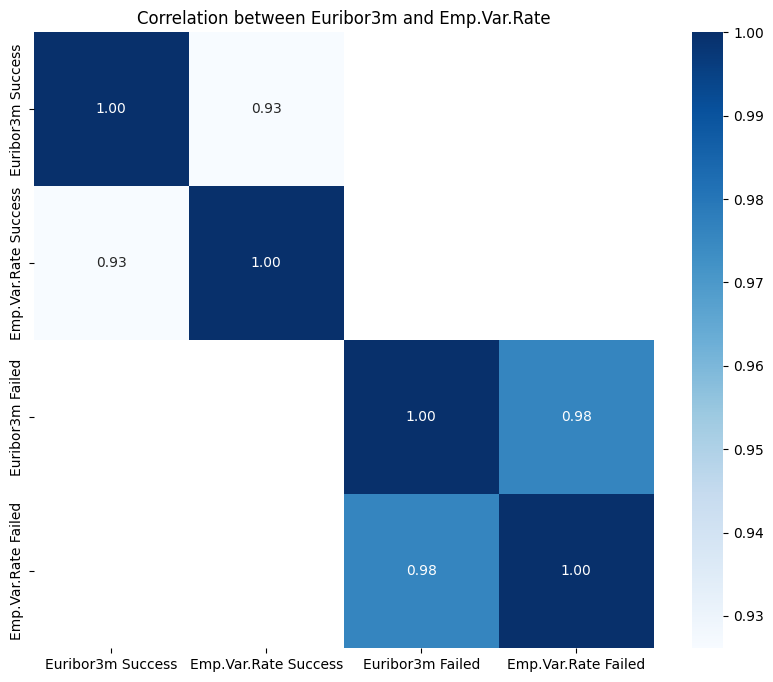

In [ ]:
# Filtering data based on the success of the calls
success_data = bank_data[bank_data['y'] == 'yes']
failed_data = bank_data[bank_data['y'] == 'no']

# Combining both success and failure data to compute correlations
correlation_data = pd.DataFrame({
    'Euribor3m Success': success_data['euribor3m'],
    'Emp.Var.Rate Success': success_data['emp.var.rate'],
    'Euribor3m Failed': failed_data['euribor3m'],
    'Emp.Var.Rate Failed': failed_data['emp.var.rate']
})

# Calculating correlation matrix
corr_matrix = correlation_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation between Euribor3m and Emp.Var.Rate')
plt.show()


The correlation between **euribor3m** and **emp.var.rate** is very high (approximately 0.93 for successful and 0.98 for unsuccessful calls). This should be the case as when more people are hired means more people with money, which leads to more spending and higher **inflation rates**.  In this case, central banks tend to increase interest rates, which aligns with the increasing of **euribor3m**.


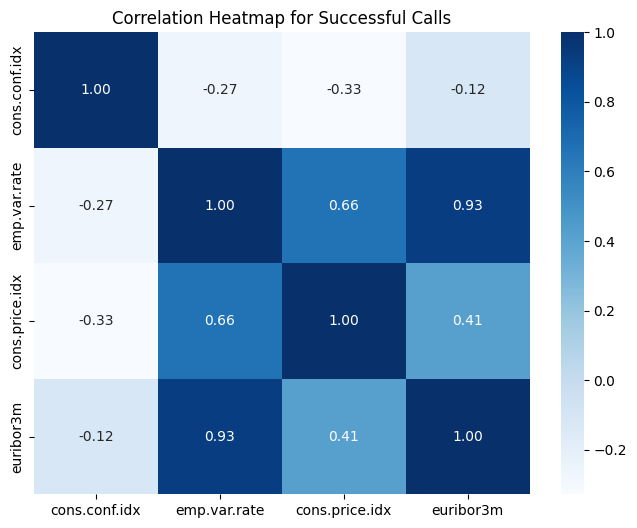

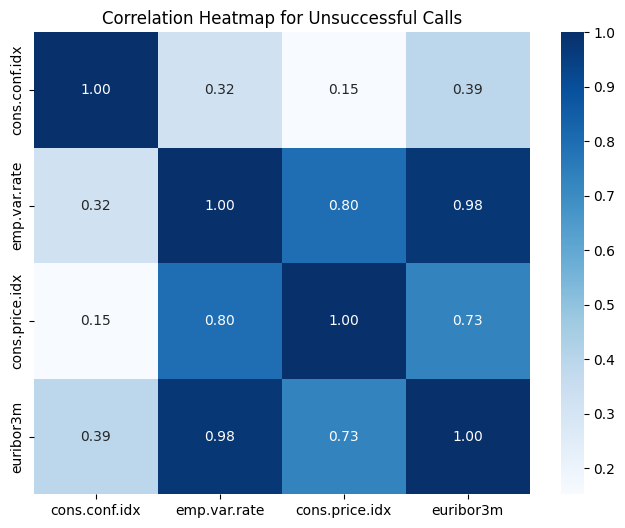

In [ ]:
# Define the columns of interest
columns_of_interest = ['cons.conf.idx', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'y']

# Filter the dataset
filtered_data = bank_data[columns_of_interest]

# Create a new column that categorizes calls as successful or not
filtered_data['call_success'] = filtered_data['y'].apply(lambda x: 'Successful' if x == 'yes' else 'Unsuccessful')

# Calculate the correlation matrix for successful calls
corr_successful = filtered_data[filtered_data['call_success'] == 'Successful'].drop(columns=['y', 'call_success']).corr()

# Calculate the correlation matrix for unsuccessful calls
corr_unsuccessful = filtered_data[filtered_data['call_success'] == 'Unsuccessful'].drop(columns=['y', 'call_success']).corr()

# Plotting the heatmap for successful calls
plt.figure(figsize=(8, 6))
sns.heatmap(corr_successful, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for Successful Calls')
plt.show()

# Plotting the heatmap for unsuccessful calls
plt.figure(figsize=(8, 6))
sns.heatmap(corr_unsuccessful, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap for Unsuccessful Calls')
plt.show()

**From correlation matrix we observe next:**
* most correlated with target feature is call duration. So we need to transform it to reduce the influence
* higly correlated features (employment rate, consumer confidence index, consumer price index) may describe clients state from different social-economic angles. Their variance might support model capacity for generalization.

# 2. Formulating hypotheses regarding individual factors (features) for conducting correct data clearining and data preparation for modeling

**Data cleaning stategy**

Since categorical variables dominate in dataset and the number of weakly correlated numeric variables is not more than 4, we need to transform categorical variables to increase the model's ability to generalize data. (we can not drop them)

Particular attention should be paid to the Duration Feature and categories that can be treated as binary. It suggests using binning and simple transformation accordingly (0 and 1)

For categories of more than 3 types of possible option (marital and education) it is proposed to use the encode targeting - it will allow correctly relate the values to the target variable and use indicated categories in numerical form.

In some cases, rescaling is proposed to normalize the data.


In [ ]:
# Replacing values with binary ()
data.contact = data.contact.map({'cellular': 1, 'telephone': 0}).astype('uint8')
data.loan = data.loan.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.housing = data.housing.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.default = data.default.map({'no': 1, 'unknown': 0, 'yes': 0}).astype('uint8')
data.pdays = data.pdays.replace(999, 0) # replace with 0 if not contact
data.previous = data.previous.apply(lambda x: 1 if x > 0 else 0).astype('uint8') # binary has contact or not

# binary if were was an outcome of marketing campane
data.poutcome = data.poutcome.map({'nonexistent':0, 'failure':0, 'success':1}).astype('uint8')

# change the range of Var Rate
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: x*-0.0001 if x > 0 else x*1)
data['emp.var.rate'] = data['emp.var.rate'] * -1
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: -np.log(x) if x < 1 else np.log(x)).astype('uint8')

# Multiply consumer index
data['cons.price.idx'] = (data['cons.price.idx'] * 10).astype('uint8')

# change the sign (we want all be positive values)
data['cons.conf.idx'] = data['cons.conf.idx'] * -1

# re-scale variables
data['nr.employed'] = np.log2(data['nr.employed']).astype('uint8')
data['cons.price.idx'] = np.log2(data['cons.price.idx']).astype('uint8')
data['cons.conf.idx'] = np.log2(data['cons.conf.idx']).astype('uint8')
data.age = np.log(data.age)

# less space
data.euribor3m = data.euribor3m.astype('uint8')
data.campaign = data.campaign.astype('uint8')
data.pdays = data.pdays.astype('uint8')

# fucntion to One Hot Encoding
def encode(data, col):
    return pd.concat([data, pd.get_dummies(col, prefix=col.name)], axis=1)

# One Hot encoding of 3 variable
data = encode(data, data.job)
data = encode(data, data.month)
data = encode(data, data.day_of_week)

# Drop tranfromed features
data.drop(['job', 'month', 'day_of_week'], axis=1, inplace=True)

In [ ]:
'''Drop the dublicates'''
data.drop_duplicates(inplace=True)

In [ ]:
'''Convert Duration Call into 5 category'''
def duration(data):
    data.loc[data['duration'] <= 102, 'duration'] = 1
    data.loc[(data['duration'] > 102) & (data['duration'] <= 180)  , 'duration'] = 2
    data.loc[(data['duration'] > 180) & (data['duration'] <= 319)  , 'duration'] = 3
    data.loc[(data['duration'] > 319) & (data['duration'] <= 645), 'duration'] = 4
    data.loc[data['duration']  > 645, 'duration'] = 5
    return data
duration(data);

Target encoding is a technique used to encode categorical variables by replacing each category with the mean of the target variable (in this case, 'y') for observations with that category.

In [ ]:
''' Target encoding for two categorical feature '''
# save target variable before transformation
y = data.y
# Create target encoder object and transoform two value
target_encode = ce.target_encoder.TargetEncoder(cols=['marital', 'education']).fit(data, y)
numeric_dataset = target_encode.transform(data)
# drop target variable
numeric_dataset.drop('y', axis=1, inplace=True)

In [ ]:
'''Check numerical data set'''
display(numeric_dataset.head(3), numeric_dataset.shape, y.shape)
display('We observe 41175 rows and 44 numerical features after transformation. Target variable shape is (41175, 0 ) as expected')

,age,marital,education,default,housing,loan,contact,duration,campaign,pdays,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,4.025352,0.101565,0.102490,1,0,0,0,3,1,0,...,False,True,False,False,False,False,True,False,False,False
1,4.043051,0.101565,0.108389,0,0,0,0,2,1,0,...,False,True,False,False,False,False,True,False,False,False
2,3.610918,0.101565,0.108389,1,1,0,0,3,1,0,...,False,True,False,False,False,False,True,False,False,False


(41175, 44)

(41175,)

'We observe 41175 rows and 44 numerical features after transformation. Target variable shape is (41175, 0 ) as expected'

# 3. The choice of metrics result

It is proposed to use ROC_AUC metrics for evaluating different models with additional monitoring of the accuracy metric dynamic.

This approach will allow us to explore models from different angles.

# 4. Building a pipline for Cross Validation and Grid Search procedures (search for optimal parameters of the model)

In [ ]:
''' Split data on train and test'''
# set global random state
random_state = 11
# split data
X_train, X_test, y_train, y_test = train_test_split(numeric_dataset, y, test_size=0.2, random_state=random_state)
# collect excess data
gc.collect()

21166

In [ ]:
display('check the shape of splitted train and test sets', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

'check the shape of splitted train and test sets'

(32940, 44)

(32940,)

(8235, 44)

(8235,)

In [ ]:
'''Build pipline of classifiers'''
# set all CPU
n_jobs = -1
# LogisticRegression
pipe_lr = Pipeline([('lr', LogisticRegression(random_state=random_state, n_jobs=n_jobs, max_iter=500))])
# RandomForestClassifier
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, oob_score=True, n_jobs=n_jobs))])
# KNeighborsClassifier
pipe_knn = Pipeline([('knn', KNeighborsClassifier(n_jobs=n_jobs))])
# DecisionTreeClassifier
pipe_dt = Pipeline([('dt', DecisionTreeClassifier(random_state=random_state, max_features='auto'))])
# BaggingClassifier
# note we use SGDClassifier as classier inside BaggingClassifier
pipe_bag = Pipeline([('bag',BaggingClassifier(base_estimator=SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500),\
                                              random_state=random_state,oob_score=True,n_jobs=n_jobs))])
# SGDClassifier
pipe_sgd = Pipeline([('sgd', SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500))])

In [ ]:
'''Set parameters for Grid Search '''
# set number
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=random_state)
# set for LogisticRegression
grid_params_lr = [{
                'lr__penalty': ['l2'],
                'lr__C': [0.3, 0.6, 0.7],
                'lr__solver': ['sag']
                }]
# set for RandomForestClassifier
grid_params_rf = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [80, 100],
                'rf__max_depth': [25, 27],
                'rf__min_samples_split': [3, 5],
                'rf__n_estimators' : [60, 70]
                }]
# set for KNeighborsClassifier
grid_params_knn = [{'knn__n_neighbors': [16,17,18]}]

# set for DecisionTreeClassifier
grid_params_dt = [{
                'dt__max_depth': [8, 10],
                'dt__min_samples_leaf': [1, 3, 5, 7]
                  }]
# set for BaggingClassifier
grid_params_bag = [{'bag__n_estimators': [10, 15, 20]}]

# set for SGDClassifier
grid_params_sgd = [{
                    'sgd__loss': ['log', 'huber'],
                    'sgd__learning_rate': ['adaptive'],
                    'sgd__eta0': [0.001, 0.01, 0.1],
                    'sgd__penalty': ['l1', 'l2', 'elasticnet'],
                    'sgd__alpha':[0.1, 1, 5, 10]
                    }]

In [ ]:
'''Grid search objects'''
# for LogisticRegression
gs_lr = GridSearchCV(pipe_lr, param_grid=grid_params_lr,
                     scoring='accuracy', cv=cv)
# for RandomForestClassifier
gs_rf = GridSearchCV(pipe_rf, param_grid=grid_params_rf,
                     scoring='accuracy', cv=cv)
# for KNeighborsClassifier
gs_knn = GridSearchCV(pipe_knn, param_grid=grid_params_knn,
                     scoring='accuracy', cv=cv)
# for DecisionTreeClassifier
gs_dt = GridSearchCV(pipe_dt, param_grid=grid_params_dt,
                     scoring='accuracy', cv=cv)
# for BaggingClassifier
gs_bag = GridSearchCV(pipe_bag, param_grid=grid_params_bag,
                     scoring='accuracy', cv=cv)
# for SGDClassifier
gs_sgd = GridSearchCV(pipe_sgd, param_grid=grid_params_sgd,
                     scoring='accuracy', cv=cv)

In [ ]:
# models that we iterate over
look_for = [gs_lr, gs_rf, gs_knn, gs_dt, gs_bag, gs_sgd]
# dict for later use
model_dict = {0:'Logistic_reg', 1:'RandomForest', 2:'Knn', 3:'DesionTree', 4:'Bagging with SGDClassifier', 5:'SGD Class'}

In [ ]:
''' Function to iterate over models and obtain results'''
# set empty dicts and list
result_acc = {}
result_auc = {}
models = []

for index, model in enumerate(look_for):
        start = time.time()
        print()
        print('+++++++ Start New Model ++++++++++++++++++++++')
        print('Estimator is {}'.format(model_dict[index]))
        model.fit(X_train, y_train)
        print('---------------------------------------------')
        print('best params {}'.format(model.best_params_))
        print('best score is {}'.format(model.best_score_))
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('---------------------------------------------')
        print('ROC_AUC is {} and accuracy rate is {}'.format(auc, model.score(X_test, y_test)))
        end = time.time()
        print('It lasted for {} sec'.format(round(end - start, 3)))
        print('++++++++ End Model +++++++++++++++++++++++++++')
        print()
        print()
        models.append(model.best_estimator_)
        result_acc[index] = model.best_score_
        result_auc[index] = auc


+++++++ Start New Model ++++++++++++++++++++++
Estimator is Logistic_reg
---------------------------------------------
best params {'lr__C': 0.6, 'lr__penalty': 'l2', 'lr__solver': 'sag'}
best score is 0.9092592592592593
---------------------------------------------
ROC_AUC is 0.9216482278347329 and accuracy rate is 0.905525197328476
It lasted for 181.181 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is RandomForest
---------------------------------------------
best params {'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__min_samples_leaf': 80, 'rf__min_samples_split': 3, 'rf__n_estimators': 70}
best score is 0.9035822707953857
---------------------------------------------
ROC_AUC is 0.926898425815701 and accuracy rate is 0.9038251366120219
It lasted for 90.588 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Knn
---------------------------------------

# 5. The choice of the most effective model, build learninig curve rate


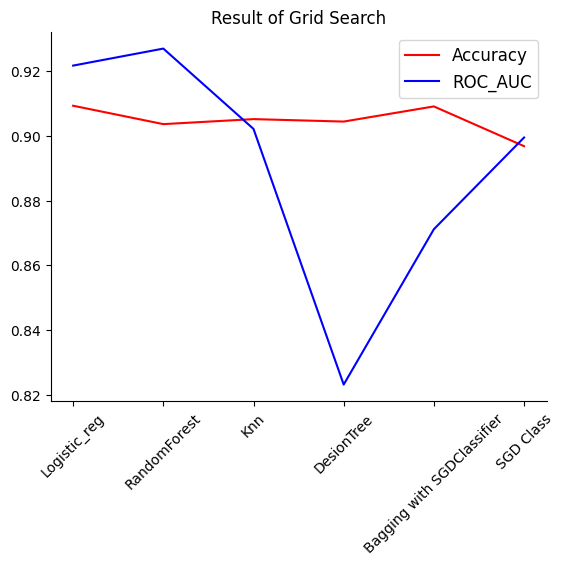

In [ ]:
plt.plot(model_dict.values(), result_acc.values(), c='r')
plt.plot(model_dict.values(), result_auc.values(), c='b')
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel('')
plt.title('Result of Grid Search')
plt.legend(['Accuracy', 'ROC_AUC'])

plt.legend(['Accuracy', 'ROC_AUC'], fontsize=12)

# Adding the style
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.show();

In [ ]:
""" Model performance during Grid Search """
pd.DataFrame(list(zip(model_dict.values(), result_acc.values(), result_auc.values())), \
                  columns=['Model', 'Accuracy_rate','Roc_auc_rate'])

,Model,Accuracy_rate,Roc_auc_rate
0,Logistic_reg,0.909259,0.921648
1,RandomForest,0.903582,0.926898
2,Knn,0.905131,0.902108
3,DesionTree,0.904372,0.823199
4,Bagging with SGDClassifier,0.909047,0.871149
5,SGD Class,0.896782,0.899445


**Best model**
Our best performed model with ROC_AUC (0.9269) metric is ** Random forest **.
This classifier could achive accuracy rate 0.903 that is average accuracy among all classifiers (0.904).

We can build graph to check RandomForestClassifier performatce with OOB score to be sure that critical hyperparametr was correctly selected during Grid Search.
As you may see it almost the same - 80 estimators with best ROC_AUC score and 90 estimators with maximun of OOB score


100%|██████████| 39/39 [01:27<00:00,  2.24s/it]


'max OOB 0.9044323011536126 and Number of Estimators 90'

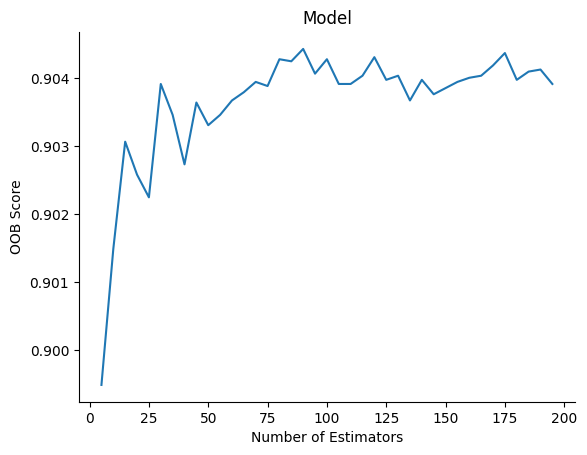

In [ ]:
def graph(model, X_train, y_train):
    obb = []
    est = list(range(5, 200, 5))
    for i in tqdm(est):
        random_forest = model(n_estimators=i, criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, \
                           max_depth=25, min_samples_leaf=80, min_samples_split=3,)
        random_forest.fit(X_train, y_train)
        obb.append(random_forest.oob_score_)
    display('max OOB {} and Number of Estimators {}'.format(max(obb), est[np.argmax(obb)]))
    plt.plot(est, obb)
    plt.title('Model')
    plt.xlabel('Number of Estimators')
    plt.ylabel('OOB Score')

    # Adding the style
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.show();

graph(RandomForestClassifier, X_train, y_train)

Let see the ROC_AUC graph

In [ ]:
''' Build graph for ROC_AUC '''

fpr, tpr, threshold = roc_curve(y_test, models[1].predict_proba(X_test)[:,1])

trace0 = go.Scatter(
    x=fpr,
    y=tpr,
    text=threshold,
    fill='tozeroy',
    name='ROC Curve')

trace1 = go.Scatter(
    x=[0,1],
    y=[0,1],
    line={'color': 'red', 'width': 1, 'dash': 'dash'},
    name='Baseline')

data = [trace0, trace1]

layout = go.Layout(
    title='ROC Curve',
    xaxis={'title': 'False Positive Rate'},
    yaxis={'title': 'True Positive Rate'})

fig = go.Figure(data, layout)
fig.show();

Curve is well distributed with tendency to False Positive Rate.  The roc auc values of the best model of 0.9269 is quite high level to make later assumptions about the data.

# 6. Feature Importance

We can build feature importance of RandomForestClassifier with best ROC_AUC score

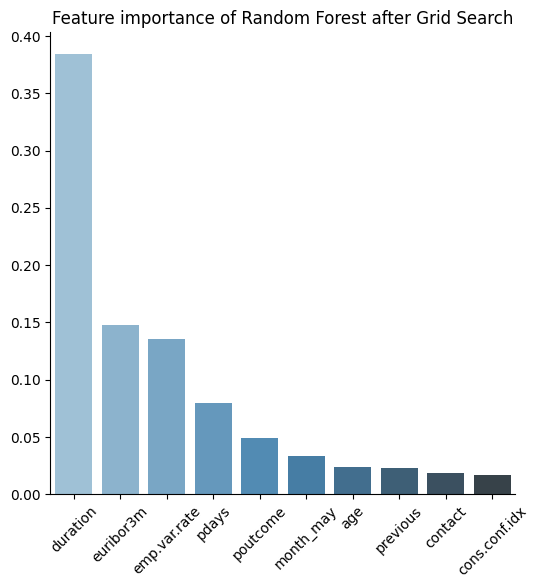

In [ ]:
''' Build bar plot of feature importance of the best model '''

def build_feature_importance(model, X_train, y_train):

    models = RandomForestClassifier(criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, \
                           max_depth=25, min_samples_leaf=80, min_samples_split=3, n_estimators=70)
    models.fit(X_train, y_train)
    data = pd.DataFrame(models.feature_importances_, X_train.columns, columns=["feature"])
    data = data.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[6,6])
    sns.barplot(x='index', y='feature', data=data[:10], palette="Blues_d")
    plt.title('Feature importance of Random Forest after Grid Search')
    plt.xticks(rotation=45)

    # Adding the style
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.xlabel('')
    plt.ylabel('')

    plt.show();

build_feature_importance(RandomForestClassifier, X_train, y_train)

# 7. Conclusions and recomendations

**What general recommendations can be offered for a successful marketing company in the future?**

This analysis can be carried out at the level of individual bank branches as does not require much resources and special knowledge (the model itself can be launched automatically with a certain periodicity).

Potentially similar micro-targeting will increase the overall effectiveness of the entire marketing company.

1. Take into account the time of the company (May is the most effective)
2. Increase the time of contact with customers (perhaps in a different way formulating the goal of the company). It is possible to use other means of communication.
3. Focus on specific categories. The model shows that students and senior citizens respond better to proposal.
4. It is imperative to form target groups based on socio-economic categories. Age, income level (not always high), profession can accurately determine the marketing profile of a potential client.

Given these factors, it is recommended to **concentrate on those consumer groups** that are potentially more promising.

The concentration of the bank’s efforts will effectively distribute the company’s resources to the main factor - the bank’s contact time with the client - it affects most of all on conversion.

The continuation of such a study may be the **formation of a clear customer profile** - by age, gender, income and other factors, as well as the adaptation of the product itself (deposit) for a specific category of consumer.
